In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## HYPERPARAMETERS

In [6]:
num_epochs = 100
batch_size = 64
glove_dim = 300
n_filters = 100

## PREPROCESSING

In [7]:
f = open("/content/drive/MyDrive/DL_A3/Trec_Train_dataset.txt","r", encoding = "ISO-8859-1")
X = []
y = []

for line in f.readlines():
  ind = line.find(':')
  y_ = line[:ind]
  x_ = line[ind:]
  x_ = " ".join(x_.split()[1:])
  X.append(x_)
  y.append(y_)

In [8]:
labels_ = np.unique(y).tolist()
y_processed = []
for label in y:
  y_processed.append(labels_.index(label))
y_processed = np.array(y_processed).astype(np.long)
y_processed

array([1, 2, 1, ..., 5, 5, 2])

In [9]:
print(labels_)

['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']


### GLOVE EMBEDDINGS/

In [ ]:
import torch
import torchtext

glove = torchtext.vocab.GloVe(name="840B",dim=glove_dim, cache="/content/drive/MyDrive/DL_A3/vectors_cache")

In [ ]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

In [ ]:
def get_tokens(arr):
  max_len=0
  tokenized=[]
  
  for text in arr:
    token=word_tokenize(text)
    tokenized.append(token)
    max_len=max(max_len,len(token))

  return tokenized, max_len

In [ ]:
def get_embedding_matrix(tokens, max_len):
  embedded = []
  for word in tokens:
    embedded.append(glove[word])
  
  for i in range(max_len-len(tokens)):
    embedded.append(glove["<x>"].numpy())
  return np.stack(embedded)

In [ ]:
tokenized, max_len = get_tokens(X)
print(max_len)

37


In [ ]:
X_processed = []
for tokens in tokenized:
  X_processed.append(get_embedding_matrix(tokens, max_len))

X_processed = np.stack(X_processed).reshape(-1,1,max_len,glove_dim)
X_processed.shape

(5452, 1, 37, 300)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, stratify=y, random_state=42)

In [ ]:
type(X_train),type(y_train)

(numpy.ndarray, numpy.ndarray)

## DATASET LOADER

In [ ]:
class TRECDataset(Dataset):
  def __init__(self, X, y):
    self.n_samples = X.shape[0]
    self.x_data = torch.from_numpy(X)   # size [n_samples, n_features]
    self.y_data = torch.from_numpy(y)   # size [n_samples, 1]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.n_samples

In [ ]:
train_dataset = TRECDataset(X_train, y_train)
test_dataset = TRECDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# x = train_dataset[:5][0]
# (nn.Conv2d(1, 100, kernel_size=(3,glove_dim))(x)).shape

In [ ]:
# x = train_dataset[:5][0]
# a = nn.Conv2d(1, 100, kernel_size=(3,glove_dim))(x)

# m = nn.AdaptiveMaxPool1d(1)
# a = m(a.reshape(5,100,35)).reshape(-1,100)

In [ ]:
# x = train_dataset[:5][0]
# b = nn.Conv2d(1, 100, kernel_size=(4,glove_dim))(x)

# m = nn.AdaptiveMaxPool1d(1)
# b = m(b.reshape(5,100,34)).reshape(-1,100)

In [ ]:
# torch.cat((a,b), dim=1).shape

## NEURAL NETWORK

In [ ]:
class CNN(nn.Module):
  
  def __init__(self, glove_dim, n_filters=100):
    super(CNN, self).__init__()
    
    self.m1 = nn.AdaptiveMaxPool1d(1)
    self.m2 = nn.AdaptiveMaxPool1d(1)
    self.m3 = nn.AdaptiveMaxPool1d(1)

    self.n_filters = n_filters

    self.conv1 = nn.Sequential(
        nn.Conv2d(1, n_filters, kernel_size=(3,glove_dim)),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(1, n_filters, kernel_size=(4,glove_dim)),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(1, n_filters, kernel_size=(5,glove_dim)),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(3*n_filters, 6),

        nn.Dropout2d(p=0.5),
    )
  
  def forward(self, x):

    a = self.conv1(x)
    a = a.view(a.size()[0],a.size()[1],a.size()[2])
    a = self.m1(a).view(-1, self.n_filters)

    b = self.conv2(x)
    b = b.view(b.size()[0],b.size()[1],b.size()[2])
    b = self.m2(b).view(-1, self.n_filters)

    c = self.conv3(x)
    c = c.view(c.size()[0],c.size()[1],c.size()[2])
    c = self.m3(c).view(-1, self.n_filters)

    z = torch.cat((a,b,c), dim=1)
    out = self.classifier(z)

    return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(glove_dim, n_filters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=3e-3)

In [ ]:
model

CNN(
  (m1): AdaptiveMaxPool1d(output_size=1)
  (m2): AdaptiveMaxPool1d(output_size=1)
  (m3): AdaptiveMaxPool1d(output_size=1)
  (conv1): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=6, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
  

### FUNCTION FOR MODEL EVALUATION

In [ ]:
def evaluate_model(model, data_loader, criterion):
    
    model.eval()
    
    n_correct = 0
    n_samples = 0

    net_loss = 0
    
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            predictions = model(features)
            
            _, predicted = torch.max(predictions.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            loss = criterion(predictions, labels)
            net_loss += loss.item()

    acc = 100.0 * n_correct / n_samples
    net_loss /= len(data_loader)

    return acc, net_loss

## TRAINING THE MODEL

In [ ]:
n_total_steps = len(train_loader)

loss_best_model = 100
PATH = "/content/drive/MyDrive/DL_A3/A3_P2_Models/best_model_840B_123.pt"

for epoch in range(num_epochs):
    for features, labels in train_loader:
        
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        predictions = model(features)
        loss = criterion(predictions, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        val_acc, val_loss = evaluate_model(model, test_loader, criterion)
        train_acc, train_loss = evaluate_model(model, train_loader, criterion)
        
        updated = ""

        if val_loss < loss_best_model:
            loss_best_model = val_loss
            updated = "++"
            torch.save({
              'epoch': epoch,
              'glove_dim': glove_dim,
              'n_filters': n_filters,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_loss': train_loss,
              'val_loss': val_loss,
              'train_acc': train_acc,
              'val_acc': val_acc,
            }, PATH)

        print (f'Epoch [{epoch+1}/{num_epochs}], Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} % {updated}')
        model.train()

## EVALUATING THE BEST MODEL

In [ ]:
PATH = "/content/drive/MyDrive/DL_A3/A3_P2_Models/best_model_840B.pt"

checkpoint = torch.load(PATH)

model = CNN(checkpoint['glove_dim'], checkpoint['n_filters']).cuda()
model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print (f'Epochs={epoch+1}, Train-Loss: {train_loss:.4f}, Val-Loss: {val_loss:.4f}, Train-Acc: {train_acc:.2f} %, Val-Acc: {val_acc:.2f} %')

Epochs=73, Train-Loss: 0.3062, Val-Loss: 0.4712, Train-Acc: 96.97 %, Val-Acc: 86.80 %


In [ ]:
model.eval()
acc_, loss_ = evaluate_model(model, test_loader, criterion)
print(f"Test Acc: {acc_}, Test Loss: {loss_}")

Test Acc: 86.80109990834097, Test Loss: 0.47116268260611427


In [ ]:
model.eval()
acc_, loss_ = evaluate_model(model, train_loader, criterion)
print(f"Train Acc: {acc_}, Train Loss: {loss_}")

Train Acc: 96.9731712909883, Train Loss: 0.3057571647391803


### ROC, Confusion Matrix, F-measure

In [ ]:
model.eval()

actual = []
pred = []

with torch.no_grad():
  for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)
    
    predictions = model(features)
    
    pred.append(predictions)
    actual.append(labels)

pred = torch.cat(pred, dim=0).cpu()
pred = nn.functional.softmax(pred, dim=1)
actual = torch.cat(actual, dim=0).cpu().numpy()

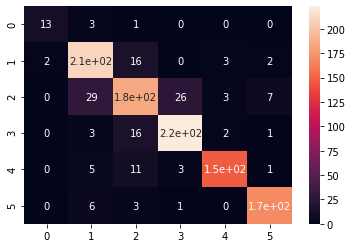

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn

_, predicted = torch.max(pred.data, 1)
cf = confusion_matrix(actual,predicted)

seaborn.heatmap(cf, annot=True)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
print("Precision:",precision_score(actual,predicted, average='macro'))
print("Recall:",recall_score(actual,predicted, average='macro'))
print("F1:",f1_score(actual,predicted, average='macro'))

Precision: 0.8755153117223973
Recall: 0.856761852800673
F1: 0.8648600910240627


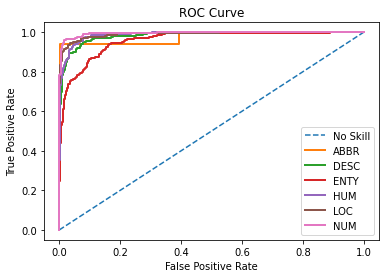

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

with torch.no_grad():
  preds = nn.functional.softmax(pred, dim=1)
  preds = preds.numpy()

  plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

  for c in range(6):
    ypred = preds[:,c]
    fpr, tpr, thresholds = roc_curve(actual, ypred, pos_label=c)
    plt.plot(fpr, tpr, linewidth=2, label=labels_[c])
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()